# Analyze uncertainty in hydrological variables from CMIP5

Looking to quantify the uncertainty of carbon cycling that imprints on things other than climate sensitivity

Got this code from Abby Swann on February 21, 2019

# Set Up Workspace

### Import Libraries

In [1]:
# Python comments are done with the # symbol

# to make plots show up below each code cell:
%matplotlib inline

# numpy is basically matlab for python. It is math tools.
import numpy as np
import numpy.matlib
import numpy.ma as ma

# xarray is for dealing with netcdf files.
import xarray as xr

import time
from datetime import timedelta
import pandas as pd

# Plotting
# basic plotting ability:
import matplotlib as mpl
import matplotlib.pyplot as plt

# we may not need this anymore...
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# tools for importing maltab binary files
from scipy.io import loadmat

# to list files in a directory
import glob

# for debugging tools
import pdb

import netCDF4 as nc
from netCDF4 import Dataset,num2date #netcdftime

# nice maps:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

import cftime

import pickle
import scipy.stats as ss
from statsmodels.tsa import stattools

In [2]:
#--- define constants
speryr=60*60*24*365
Lv = 2.45e6   # J/kg   # in CLM 2.501e6, 
sperday=60*60*24

#----- List of all of the models
modellist=['bcc-csm1-1','CanESM2','CESM1-BGC','GFDL-ESM2M','HadGEM2-ES', 'IPSL-CM5A-LR','NorESM1-ME','MPI-ESM-LR']
#modellist=['BCC-CSM2-MR','CanESM5','CESM2','CNRM-CM6-1','CNRM-ESM2-1','GISS-E2-1-G','MIROC6','MRI-ESM2-0']
#modellist = ['CESM2']

runnamelist = ['1pctCO2-bgc']  #, 'esmControl', 'rcp45','esmFdbk2','esmHistorical'] # other possible run names for which I have some data

# list of all of the variables wanted
#varlist=['hfls', 'hfss','hurs','mrro','mrso','pr','ps','sfcWind','tas','tran','gpp','lai','evspsbl']
varlist=['hfls', 'hfss', 'hurs', 'ps', 'evspbl','tas','pr','sfcWind','tran','gpp','lai','mrro','mrso','mrsls','rlds','rlus','rsds','rsdt','rsus','rsut']

# weights for months
monthweights = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

plotfilepath ='/home/disk/eos3/mp586/cmip5_plots'




### Define functions to load variables and make plots

In [3]:
def grab_cmip_dataset(cdict,Mname,Rname,Vname):
    
    nametag = Mname +'_' +Rname +'_' +Vname
    #print('getting dataset for: ' +nametag)
    
    if nametag in cdict:
        DS = cdict[nametag] # open the dataset
        
    elif Vname== 'RUNOFF': # convert units
        unitconversion=sperday
        oldname='mrro'
        oldnametag = Mname +'_' +Rname +'_' +oldname
        if oldnametag in cdict:
            DS = cdict[oldnametag] # open the dataset
            oldarray = DS[oldname] # get the values
            DS[Vname]=oldarray*unitconversion # convert the unit in the dataset
        else: # it isn't a variable/model/run combo in the dictionary
            print(oldnametag +' not in the dictionary')
            return #exit here
        
    elif Vname == 'PRECIP': # convert units
        unitconversion=sperday
        oldname='pr'
        oldnametag = Mname +'_' +Rname +'_' +oldname
        if oldnametag in cdict:
            DS = cdict[oldnametag] # open the dataset
            oldarray = DS[oldname] # get the values
            DS[Vname]=oldarray*unitconversion # convert the unit in the dataset
        else: # it isn't a variable/model/run combo in the dictionary
            print(oldnametag +' not in the dictionary')
            return #exit here
        
    elif Vname == 'GPP': # convert units
        unitconversion=sperday
        oldname='gpp'
        oldnametag = Mname +'_' +Rname +'_' +oldname
        if oldnametag in cdict:
            DS = cdict[oldnametag] # open the dataset
            oldarray = DS[oldname] # get the values
            DS[Vname]=oldarray*unitconversion # convert the unit in the dataset
        else: # it isn't a variable/model/run combo in the dictionary
            print(oldnametag +' not in the dictionary')
            return #exit here
        
    elif Vname == 'ET': # convert units
        unitconversion=sperday
        oldname='evspsbl'
        oldnametag = Mname +'_' +Rname +'_' +oldname
        if oldnametag in cdict:
            DS = cdict[oldnametag] # open the dataset
            oldarray = DS[oldname] # get the values
            DS[Vname]=oldarray*unitconversion # convert the unit in the dataset
        else: # it isn't a variable/model/run combo in the dictionary
            print(oldnametag +' not in the dictionary')
            return #exit here
    
    elif nametag == 'CanESM2_1pctCO2_hurs': #correct the units due to error in the original dataset
        unitconversion=100
        DS = cdict[nametag] # open the dataset
        oldarray = DS[Vname] # get the values
        DS[Vname]=oldarray*unitconversion # convert the unit in the dataset

    elif nametag == 'IPSL-CM5A-LR_1pctCO2_mrro': #correct the units due to error in the original dataset
        unitconversion=48
        DS = cdict[nametag] # open the dataset
        oldarray = DS[Vname] # get the values
        DS[Vname]=oldarray*unitconversion # convert the unit in the dataset
    
    elif Vname == 'WUE': # create a variable from multiple variables
        # WUE=gC/water lost
        # gpp is in kgC/m2/s => convert to gC/m2/s
        # tran is in kgwater/m2/s
        # WUE = gpp/tran = gC/kgwater
        unitconversion=1e-3
        oldnametag1 = Mname +'_' +Rname +'_' +'gpp'
        oldnametag2 = Mname +'_' +Rname +'_' +'tran'
        if (oldnametag1 in cdict and oldnametag2 in cdict):
            DS = cdict[oldnametag1] # open the dataset
            oldarray1 = DS['gpp'] # get the values
            DS2= cdict[oldnametag2] # open the dataset
            oldarray2 = DS2['tran'] # get the values
            wuetmp=(oldarray1/oldarray2)*unitconversion #np.multiply(np.divide(oldarray1,oldarray2),unitconversion) # convert the unit in the dataset
            DS[Vname]= np.minimum(wuetmp,100)
        else: # it isn't a variable/model/run combo in the dictionary
            print(oldnametag1 +' or ' +oldnametag2 +' not in the dictionary')
            return #exit here

    elif Vname == 'VPD': # create a variable from multiple variables
        unitconversion=1e-3
        Rv=461 # J/kg/K
        oldnametag1 = Mname +'_' +Rname +'_' +'hurs'
        oldnametag2 = Mname +'_' +Rname +'_' +'tas'
        if (oldnametag1 in cdict and oldnametag2 in cdict):
            DS = cdict[oldnametag1] # open the dataset
            RH = DS['hurs'] # get the values
            DS2= cdict[oldnametag2] # open the dataset
            T = DS2['tas'] # get the values
            T = T - 273.15 #convert from K to C
            RH = RH/100 #convert from scale of percent to fraction
            estarT = 610.8*np.exp(Lv/Rv*(1/273.15 - 1/(T + 273.15)))  #T in celsius, final unit Pa
            VPD=estarT*(1-RH)    
            DS[Vname]=VPD # convert the unit in the dataset        
        else: # it isn't a variable/model/run combo in the dictionary
            print(oldnametag1 +' or ' +oldnametag2 +' not in the dictionary')    
            return #exit here
        
    elif Vname == 'PmE': # create a variable from multiple variables
        unitconversion=1e-3
        oldname1='pr'
        oldname2='evspsbl'
        oldnametag1 = Mname +'_' +Rname +'_' +oldname1
        oldnametag2 = Mname +'_' +Rname +'_' +oldname2
        if (oldnametag1 in cdict and oldnametag2 in cdict):
            DS = cdict[oldnametag1] # open the dataset
            P = DS[oldname1] # get the values
            DS2= cdict[oldnametag2] # open the dataset
            E = DS2[oldname2]*sperday # get the values
 
            DS[Vname]=P-E # convert the unit in the dataset        
        else: # it isn't a variable/model/run combo in the dictionary
            print(oldnametag1 +' or ' +oldnametag2 +' not in the dictionary')    
            return #exit here    
        
    elif Vname == 'Q': # create a variable from multiple variables
        # Q is specific humidity at the surface in units of kg water/kg air
        # hurs is in %
        # tas is in kelvin
        # ps is surface pressure in Pa
        unitconversion=1e-3
        Rv=461 # J/kg/K
        oldnametag1 = Mname +'_' +Rname +'_' +'hurs'
        oldnametag2 = Mname +'_' +Rname +'_' +'tas'
        oldnametag3 = Mname +'_' +Rname +'_' +'ps'
        if (oldnametag1 in cdict and oldnametag2 in cdict):
            DS = cdict[oldnametag1] # open the dataset
            RH = DS['hurs'] # get the values
            DS2= cdict[oldnametag2] # open the dataset
            T = DS2['tas'] # get the values
            T = T - 273.15 #convert from K to C
            DS3= cdict[oldnametag3] # open the dataset
            PS = DS3['ps'] # get the values
            RH = RH/100 #convert from scale of percent to fraction
            estarT = 610.8*np.exp(Lv/Rv*(1/273.15 - 1/(T + 273.15)))  #T in celsius, final unit Pa
            Q=0.622*RH*estarT/PS   # final unit in kg/kg
            DS[Vname]=Q # convert the unit in the dataset        
        else: # it isn't a variable/model/run combo in the dictionary
            print(oldnametag1 +' or ' +oldnametag2 +' or ' +oldnametag3 +' not in the dictionary')    
            return #exit here   
        
    else: # it isn't a variable/model/run combo in the dictionary
        print(nametag +' not in the dictionary')
        return #exit here
    
    return DS

In [4]:
def quick_map(mapdata,lat,lon,title=None,cb_ttl=None,cmap=None,clim=None,filepath=None,show=None,sigmask=None,p=None):
    
    fig = plt.figure(figsize=(8,7))
    
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

    #cs = plt.contourf(cyclic_lons,lat,cyclic_data,60,transform=ccrs.PlateCarree(),extend='both')#,vmin=clim[0],vmax=clim[1])
    cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
    

    # Choose your colormap
    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)
    
#     cmap = plt.get_cmap()
#     cmap.set_bad(color='black')
   
    
    if title:
        plt.title(title,fontsize=16,y=1.05)
        
    if clim:
        plt.clim(clim)  
        cs.set_clim(clim[0],clim[1])
        cs.set_clim(clim)
        
    cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
    cbar.ax.tick_params(labelsize=14) 
    
    if clim:
        cbar.set_clim(clim)

    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=14)
    
   
    # add hatching for significance
    if p:
        cyclic_sig, cyclic_lons = add_cyclic_point(sigmask,coord=lon)
        #hatch = plt.pcolor(cyclic_lons,lat,cyclic_sig,hatch='xxx',alpha=0.,transform=ccrs.PlateCarree()); 

        CLN, CLT = np.meshgrid(cyclic_lons,lat)

        # only put the hatches where the sigmask is >0.5
        #cyclic_sig = np.ma.masked_where(cyclic_sig<p,cyclic_sig)
        lat_sig = np.ma.masked_where(cyclic_sig<p,CLT)
        lat_sig = np.ma.masked_where(np.isnan(cyclic_sig),lat_sig)
        lon_sig = np.ma.masked_where(cyclic_sig<p,CLN)
        lon_sig = np.ma.masked_where(np.isnan(cyclic_sig),lon_sig)

        hatch = ax.scatter(lon_sig,lat_sig,marker='x',s=2,c=[0.6, 0.6, 0.6],alpha=0.8,transform=ccrs.PlateCarree(),)

    ax.patch.set_alpha(0.0)
    
    if show:
        plt.show()
    
    #if filepath:
        # save figure if path given
    #    fig.savefig(filepath+'.png',dpi=300,facecolor=None,edgecolor=None,bbox_inches='tight',transparent=True,pad_inches=0.01)
         #fig.savefig(plotfilepath +varname +'_' +runname +'_deltamaps.png', bbox_inches='tight') 
        #print('done saving file')

    plt.close()
    
    return fig,ax,cs,cbar

In [5]:
def plot_allmaps_run(cmipchoice, runnamelistF,modellistF,varname,clim=None,unitname=None,copt=None, cmap=None):
    #---- Loop over runs    
    for rn in range(len(runnamelistF)):
        runname = runnamelistF[rn]
        print(runname)
        
        #fig,axes = plt.subplots(5,2,figsize=(10,15),subplot_kw={'projection': ccrs.Robinson()}) # also works to get projection into subplots
        fig = plt.figure(figsize=(15,10))


        #To loop over models and runs
        for md in range(len(modellistF)):
            modelname = modellistF[md]
            
            #print(modelname +' ' +runname +' ' +varname)
            # get dataset
            ds = grab_cmip_dataset(cmipchoice,modelname,runname,varname)

            if ds is not None: # 'ds' in locals():

                delta = ds[varname].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')

                # - I don't understand why these don't work
                #quick_map(delta.values,ds.lat.values,ds.lon.values,title='Delta ' +varname)
                #delta.plot

                mapdata = delta.values
                lat = ds['lat'].values
                lon = ds['lon'].values   

                ax=plt.subplot(4,3,md+1,projection=ccrs.Robinson())

                # use this in combination with setting the projection at the fig level
                #ax=axes.flatten()[md]
                #plt.sca(ax)

                ax.coastlines()
                ax.set_global()
                # in cartopy you can tell it your data is on something round, to avoid the stupid empty line
                # down the prime meridian using the cyclic_point functionality:
                cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

                # plot our data:
                cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())

                # Choose your colormap
                if cmap:
                    plt.set_cmap(cmap)
                else:
                    plt.set_cmap(plt.cm.RdYlBu)
                    
                if copt:
                    if copt==-1:
                        plt.set_cmap(plt.cm.RdYlBu_r)
                    elif copt==1:
                        plt.set_cmap(plt.cm.BrBG)
                    

                # set a title if you want:
                #plt.title('Delta ' +varname +', ' +modelname +'_' +runname,fontsize=16,y=1.05)
                plt.title(modelname +', ' +runname,fontsize=12,y=1)


                # you have to do it seperately for the plot and colorbar-its always self consistent but
                # can be really ugly if you only do one
                if clim: 
                    plt.clim(clim) 

                # show the plot:
                #plt.show()

        # adjust the subplots to make space for a colorbar and to decrease spacing between subplots
        #subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
        plt.subplots_adjust(bottom=0.08, right=None, top=None, wspace=.02, hspace=.15)

        # make an axes for the colorbar
        #cax = plt.axes([left, bottom, width, height])
        cax = plt.axes([0.25, 0.05, 0.5, 0.018],frameon='no')

        # add a colorbar:
        cbar = plt.colorbar(cax=cax,orientation='horizontal',extend='both')#,pad=.02, shrink=0.9) #use cax here, which means getting rid of pad
        cbar.ax.tick_params(labelsize=14) 

        # set color limits for the colorbar
        if clim:
            cs.set_clim(clim)
            cbar.set_clim(clim)

        # put a label on the colorbar, e.g. with the units of your field
        cbar.set_label(varname +' (' +unitname +')',fontsize=14)

        # show the plot:
        plt.show()

        # save the plot
        fig.savefig(plotfilepath +varname +'_' +runname +'_deltamaps.png', bbox_inches='tight')
        
        print('done saving file')
        
        # close the plot (so python stops trying to hold on to it in memory; you can
        # still look at it at this point, but you're done editing)
        plt.close()

In [6]:
def plot_zonal_land_spread(runnamelistF,modellistF,varname,unitname=None):
    #---- Loop over runs    
    for rn in range(len(runnamelistF)):
        runname = runnamelistF[rn]
        print(runname)
        
        #fig,axes = plt.subplots(5,2,figsize=(10,15),subplot_kw={'projection': ccrs.Robinson()}) # also works to get projection into subplots
        fig = plt.figure(figsize=(10,5))
        ax=plt.axes()

        #To loop over models and runs
        for md in range(len(modellistF)):
            modelname = modellistF[md]
            
            #print(modelname +' ' +runname +' ' +varname)
            # get dataset
            ds = grab_cmip_dataset(cmip6_dict,modelname,runname,varname)
            

            
            if ds is not None: # 'ds' in locals():
                # calculate the difference between end of time series and beginning
                delta = ds[varname].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')
                
                # calculate the area-weighted zonal average over land
                ds = grab_cmip_dataset(cmip6_dict,modelname,runname,varname)
                delta = ds[varname].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')

                # get land fraction and grid area
                ds_area = cmip6_dict[modelname +'_areacella']
                da_area = ds_area['areacella']
                ds_land = cmip6_dict[modelname +'_sftlf'] # in values of 0 to 100
                da_land = ds_land['sftlf']

                # make land area weights
                landaream2 = da_area*da_land/100
                landareaweights = landaream2/landaream2.sum(skipna=True)

                # caluclate an area-weighted zonal mean. Use the values in the land area because of minor mismatch in grid from land to atm
                zonalmean=(delta*landareaweights.values[:]).sum(dim='lon',skipna=True)

                # plot a zonal mean on an existing figure axis
                ax.plot(ds['lat'],zonalmean)
                

        # set a title if you want:
        #plt.title('Delta ' +varname +', ' +modelname +'_' +runname,fontsize=16,y=1.05)
        plt.title(varname +', ' +runname +' zonal mean',fontsize=14,y=1)

        # show the plot:
        plt.show()

        # save the plot
        fig.savefig(plotfilepath +varname +'_' +runname +'_zonalplots.png', bbox_inches='tight')
        
        print('done saving file')
        
        # close the plot (so python stops trying to hold on to it in memory; you can
        # still look at it at this point, but you're done editing)
        plt.close()

In [7]:
def whittaker_plot(runnamelistF,modellistF,varname,unitname=None):
    #---- Loop over runs    
    for rn in range(len(runnamelistF)):
        runname = runnamelistF[rn]
        print(runname)
        
        #fig,axes = plt.subplots(5,2,figsize=(10,15),subplot_kw={'projection': ccrs.Robinson()}) # also works to get projection into subplots
        fig = plt.figure(figsize=(10,5))
        ax=plt.axes()

        #To loop over models and runs
        for md in range(len(modellistF)):
            modelname = modellistF[md]
            
            #print(modelname +' ' +runname +' ' +varname)
            # get dataset
            ds = grab_cmip_dataset(cmip6_dict,modelname,runname,varname)
            
            if ds is not None: # 'ds' in locals():
                # calculate the difference between end of time series and beginning
                delta = ds[varname].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')
                temp = ds['tas'].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')
                precip = ds['p'].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')
                
                # calculate the area-weighted zonal average over land
                ds = grab_cmip_dataset(cmip6_dict,modelname,runname,varname)
                delta = ds[varname].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')

                # get land fraction and grid area
                ds_area = cmip6_dict[modelname +'_areacella']
                da_area = ds_area['areacella']
                ds_land = cmip6_dict[modelname +'_sftlf'] # in values of 0 to 100
                da_land = ds_land['sftlf']

                # make land area weights
                landaream2 = da_area*da_land/100
                landareaweights = landaream2/landaream2.sum(skipna=True)

                # caluclate an area-weighted zonal mean. Use the values in the land area because of minor mismatch in grid from land to atm
                zonalmean=(delta*landareaweights.values[:]).sum(dim='lon',skipna=True)

                # plot a zonal mean on an existing figure axis
                ax.plot(ds['lat'],zonalmean)
                

        # set a title if you want:
        #plt.title('Delta ' +varname +', ' +modelname +'_' +runname,fontsize=16,y=1.05)
        plt.title(varname +', ' +runname +' zonal mean',fontsize=14,y=1)

        # show the plot:
        plt.show()

        # save the plot
        fig.savefig(plotfilepath +varname +'_' +runname +'_zonalplots.png', bbox_inches='tight')
        
        print('done saving file')
        
        # close the plot (so python stops trying to hold on to it in memory; you can
        # still look at it at this point, but you're done editing)
        plt.close()

### Load the dictionary of CMIP5 output

In [8]:
#load cmip dictionary
#exec(open("/home/disk/p/czarakas/Research/Code/CMIP_Analysis/load_cmip_dictionary.py").read())

cmip5_dict = pickle.load(open("/home/disk/eos3/mp586/cmip5_dict.pickle","rb"))
#cmip6_dict = pickle.load(open("cmip6_dict.pickle","rb"))

In [9]:
# ds = grab_cmip_dataset(cmip5_dict,'BNU-ESM','1pctCO2','hfss')
# print(ds)

In [10]:
# print(cmip5_dict)

### 0. Plot Zonal Means

fig = plt.figure(figsize=(10,5))
ax=plt.axes()
varname='lai'
runname='1pctCO2'

for modelname in modellist:

    ds = grab_cmip_dataset(cmip5_dict,modelname,runname,varname)
    if ds != None:
        delta = ds[varname].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')

        # get land fraction and grid area
        ds_area = cmip5_dict[modelname +'_areacella']
        da_area = ds_area['areacella']
        ds_land = cmip5_dict[modelname +'_sftlf'] # in values of 0 to 100
        da_land = ds_land['sftlf']

        # make land area weights
        landaream2 = da_area*da_land/100
        landareaweights = landaream2/landaream2.sum(skipna=True)
        landareaweights_zonal=landareaweights.sum(dim='lon',skipna=True)

        # caluclate an area-weighted zonal mean. Use the values in the land area because of minor mismatch in grid from land to atm
        if varname=='lai':
                zonalmean=(delta*landareaweights.values[:]).sum(dim='lon',skipna=True)
                zonalmean=zonalmean.values[:]/landareaweights_zonal.values[:]
        else:
                zonalmean=(delta).mean(dim='lon',skipna=True)

                
        # plot a zonal mean
        ax.plot(ds['lat'],zonalmean,label=modelname)
plt.legend()

KeyboardInterrupt: 

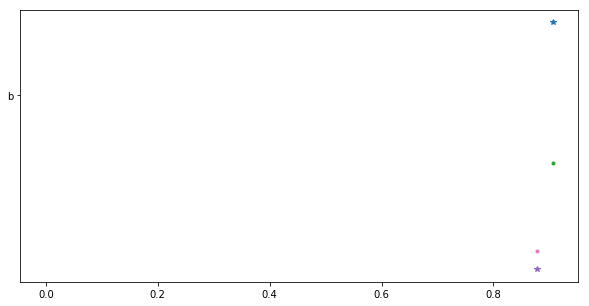

In [15]:
# MP586

fig = plt.figure(figsize=(10,5))
ax=plt.axes()
runlist=['1pctCO2','esmFixClim1']
colors = ['b','r','g','k','y','m','c','C1']
symbols = ['*','.']

ci = 0
for modelname in modellist:

    sh_ctl = grab_cmip_dataset(cmip5_dict,modelname,'esmControl','hfss')
    lh_ctl = grab_cmip_dataset(cmip5_dict,modelname,'esmControl','hfls')
    pr_ctl = grab_cmip_dataset(cmip5_dict,modelname,'esmControl','pr')
    pr_ctl_timemean = pr_ctl['pr'].mean(dim='time')


    sh_ctl_amazon = sh_ctl['hfss'].isel(time=range((140-20)*12,140*12)).sel(lon=slice(-65.+180., -52.+180.)).sel(lat=slice(-10., 3.)).mean(dim=['time','lat','lon'])
    lh_ctl_amazon = lh_ctl['hfls'].isel(time=range((140-20)*12,140*12)).sel(lon=slice(-65.+180., -52.+180.)).sel(lat=slice(-10., 3.)).mean(dim=['time','lat','lon'])

    evap_frac_ctl = lh_ctl_amazon / (sh_ctl_amazon + lh_ctl_amazon)
    
#     ds_area = cmip5_dict[modelname +'_areacella']
#     da_area = ds_area['areacella']
#     ds_land = cmip5_dict[modelname +'_sftlf'] # in values of 0 to 100
#     da_land = ds_land['sftlf']

#     # make land area weights
#     landaream2 = da_area*da_land/100
#     landareaweights = landaream2/landaream2.sum(skipna=True)
#     landareaweights_zonal=landareaweights.sum(dim='lon',skipna=True)

    si = 0
    for runname in runlist: 
        pr_pertb = grab_cmip_dataset(cmip5_dict,modelname,runname,'pr')
        pr_pertb_timemean = pr_pertb['pr'].isel(time = range((140-20)*12,140*12)).mean(dim='time')
        dpr_amazon = ((pr_pertb_timemean - pr_ctl_timemean)*86400).sel(lon=slice(-65.+180., -52.+180.)).sel(lat=slice(-10., 3.)).mean(dim=['lat','lon'])
        ax.plot(evap_frac_ctl,dpr_amazon,symbols[si], colors[ci],label = modelname+','+runname)
        si += 1
ci += 1    
# plt.legend()

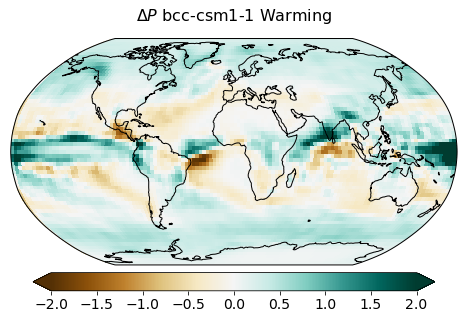

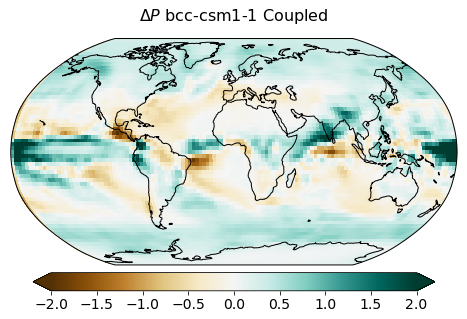

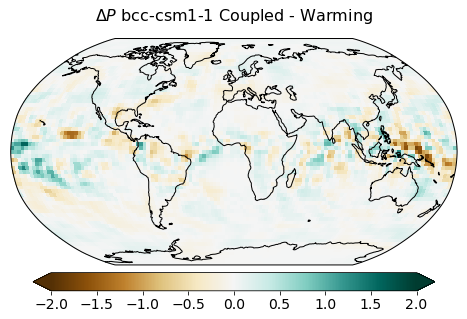

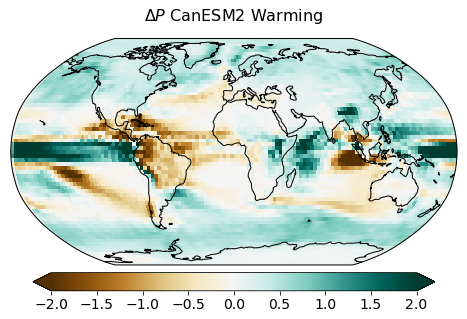

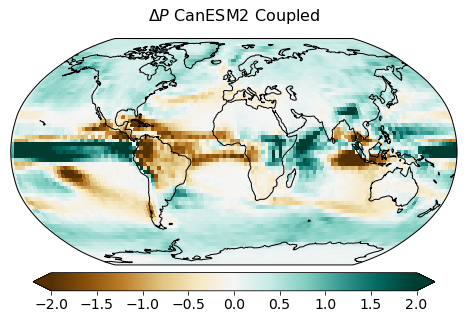

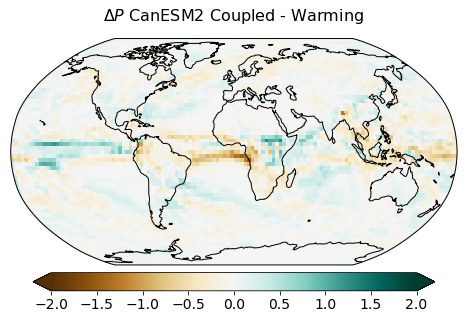

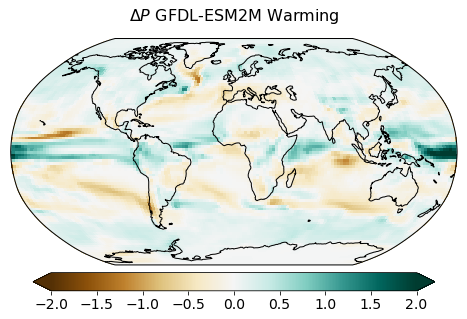

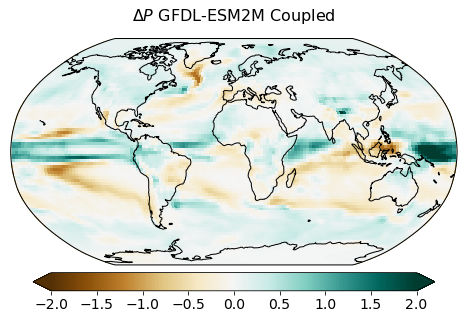

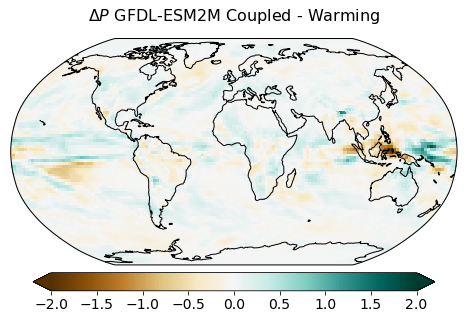

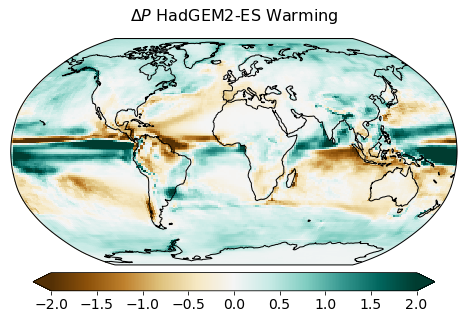

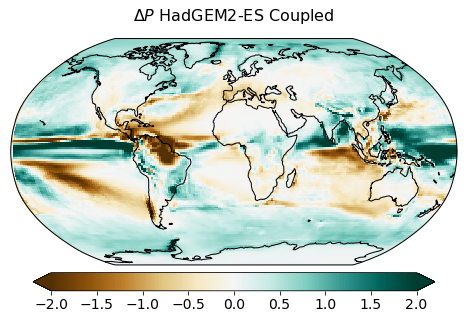

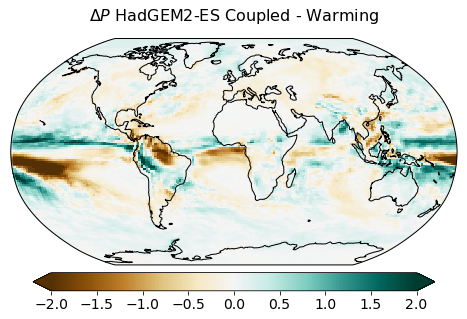

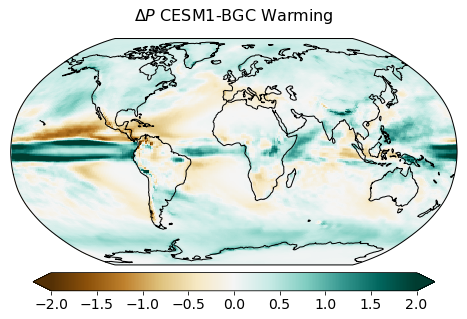

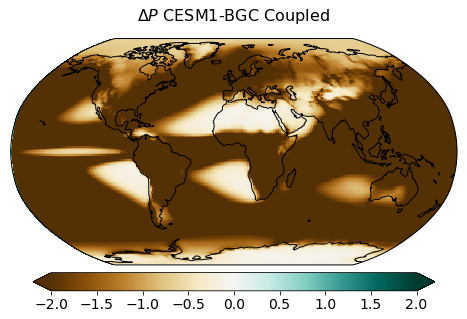

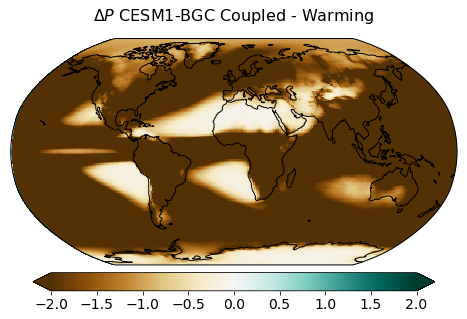

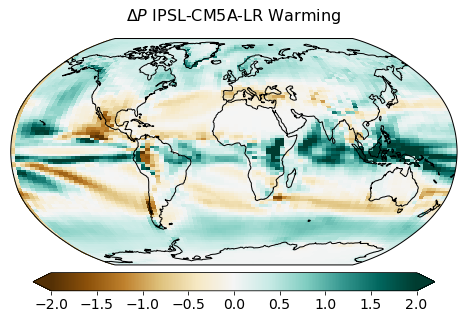

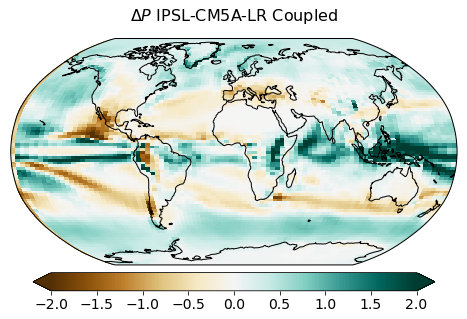

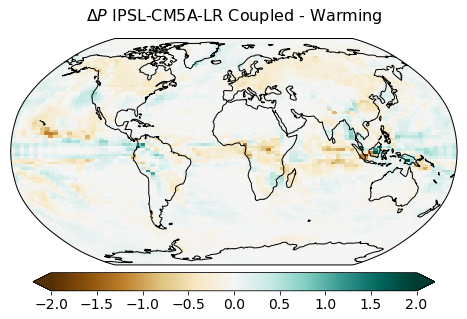

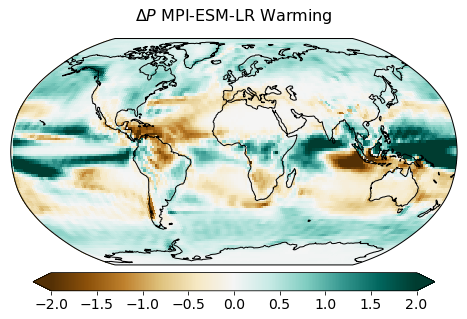

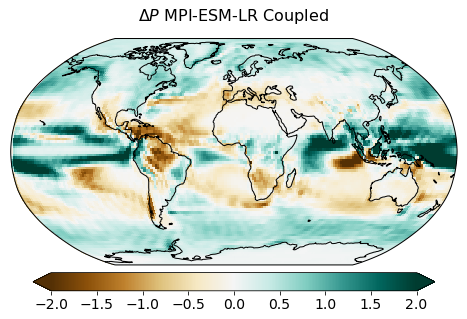

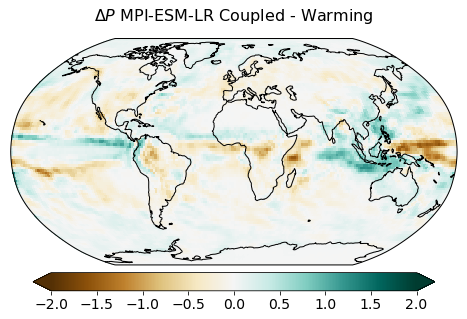

In [16]:
#MP586

runlist=['1pctCO2','esmFdbk1']
#colors = ['b','r','g','k','y','m','c','C1']
#symbols = ['*','.']
modellist=['bcc-csm1-1','CanESM2','GFDL-ESM2M','HadGEM2-ES','CESM1-BGC','IPSL-CM5A-LR','MPI-ESM-LR']

mi = 0
for modelname in modellist:
    
    pr_ctl = grab_cmip_dataset(cmip5_dict,modelname,'esmControl','pr')
    pr_ctl_timemean = pr_ctl['pr'].mean(dim='time')
    pr_pertb_coupled = grab_cmip_dataset(cmip5_dict,modelname,'1pctCO2','pr')
    pr_pertb_coupled_timemean = pr_pertb_coupled['pr'].isel(time = range((140-20)*12,140*12)).mean(dim='time')
    pr_pertb_warming = grab_cmip_dataset(cmip5_dict,modelname,'esmFdbk1','pr')
    pr_pertb_warming_timemean = pr_pertb_warming['pr'].isel(time = range((140-20)*12,140*12)).mean(dim='time')

    lats = pr_pertb_warming_timemean.lat
    lons = pr_pertb_warming_timemean.lon

    quick_map((pr_pertb_warming_timemean - pr_ctl_timemean)*86400.,lats,lons,title= '$\Delta P$ '+modelname+' Warming',cb_ttl=None,cmap='BrBG',clim=[-2.,2.],filepath=None,show=True,sigmask=None,p=None)
    quick_map((pr_pertb_coupled_timemean - pr_ctl_timemean)*86400.,lats,lons,title= '$\Delta P$ '+modelname+' Coupled',cb_ttl=None,cmap='BrBG',clim=[-2.,2.],filepath=None,show=True,sigmask=None,p=None)
    quick_map((pr_pertb_coupled_timemean - pr_pertb_warming_timemean)*86400.,lats,lons,title= '$\Delta P$ '+modelname+' Coupled - Warming',cb_ttl=None,cmap='BrBG',clim=[-2.,2.],filepath=None,show=True,sigmask=None,p=None)



/home/disk/eos3/mp586/anaconda3/envs/claire_env_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/eos3/mp586/anaconda3/envs/claire_env_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


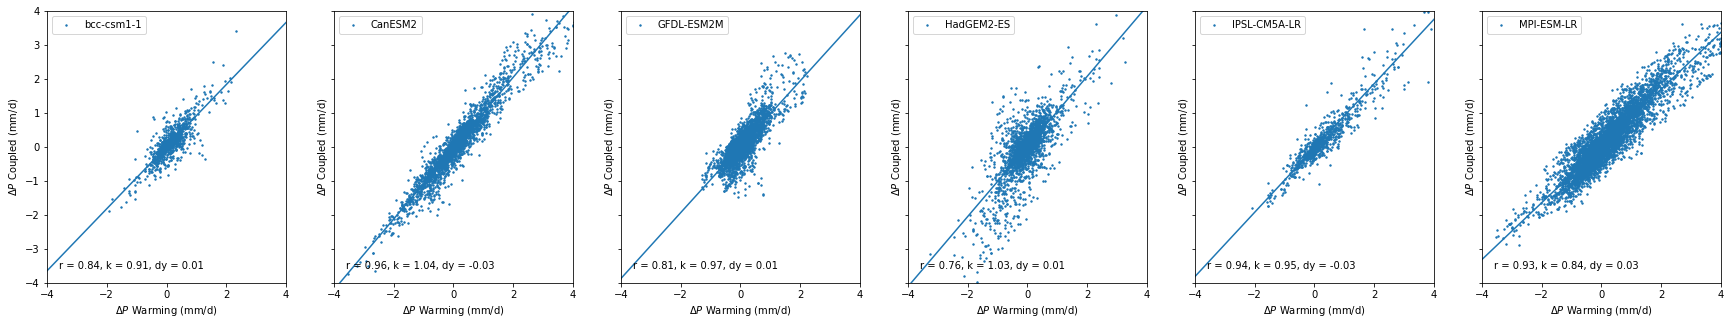

In [17]:
#MP586
from scipy.stats import linregress as linreg

# runlist=['1pctCO2','esmFixClim1']

modellist=['bcc-csm1-1','CanESM2','GFDL-ESM2M','HadGEM2-ES', 'IPSL-CM5A-LR','MPI-ESM-LR']

mi = 0
fig, ax = plt.subplots(1,6,sharey = True, sharex = True, figsize = (30,5))
for modelname in modellist:
    
    somoco = grab_cmip_dataset(cmip5_dict,modelname,'esmControl','mrso')
    somocomean = xr.DataArray(somoco['mrso'].mean(dim='time').sel(lat=slice(-30.,30.)))
    somoco_1d = np.asarray(somocomean).flatten()
    mask = ~np.isnan(somoco_1d)
    pr_ctl = grab_cmip_dataset(cmip5_dict,modelname,'esmControl','pr')
    pr_ctl_timemean = pr_ctl['pr'].mean(dim='time').sel(lat=slice(-30.,30.))*86400.
    pr_pertb_coupled = grab_cmip_dataset(cmip5_dict,modelname,'1pctCO2','pr')
    pr_pertb_coupled_timemean = pr_pertb_coupled['pr'].isel(time = range((140-20)*12,140*12)).mean(dim='time').sel(lat=slice(-30.,30.))*86400.
    pr_pertb_warming = grab_cmip_dataset(cmip5_dict,modelname,'esmFdbk1','pr')
    pr_pertb_warming_timemean = pr_pertb_warming['pr'].isel(time = range((140-20)*12,140*12)).mean(dim='time').sel(lat=slice(-30.,30.))*86400.

    lats = pr_pertb_warming_timemean.lat
    lons = pr_pertb_warming_timemean.lon
    
    dP_warming = np.asarray(pr_pertb_warming_timemean - pr_ctl_timemean).flatten()
    dP_coupled = np.asarray(pr_pertb_coupled_timemean - pr_ctl_timemean).flatten()
    
    ax[mi].scatter(dP_warming[mask],dP_coupled[mask],s = 2.,label = modelname)
    ax[mi].set_xlim(-4.,4.)
    ax[mi].set_ylim(-4.,4.)
    ax[mi].set_ylabel('$\Delta P$ Coupled (mm/d)')
    ax[mi].set_xlabel('$\Delta P$ Warming (mm/d)')

    ax[mi].legend(loc='upper left')
    [k,dy,r,p,stderr] = linreg(dP_warming[mask],dP_coupled[mask]) # aa = 8.4, dq = -32
    x1 = np.linspace(-4.,4.,500)
    y = k*x1 + dy
    ax[mi].plot(x1,y)
    ax[mi].annotate('r = '+str("%.2f" % r)+', k = '+str("%.2f" % k)+', dy = '+str("%.2f" % dy), xy=(0.05,0.05), xycoords='axes fraction')
    mi += 1
                                                                                                                
plt.show()
    

/home/disk/eos3/mp586/anaconda3/envs/claire_env_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/eos3/mp586/anaconda3/envs/claire_env_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'time' (time: 3000)>
array([cftime.DatetimeNoLeap(1, 1, 16, 12, 0, 0, 0, 2, 16),
       cftime.DatetimeNoLeap(1, 2, 15, 0, 0, 0, 0, 4, 46),
       cftime.DatetimeNoLeap(1, 3, 16, 12, 0, 0, 0, 5, 75), ...,
       cftime.DatetimeNoLeap(250, 10, 16, 12, 0, 0, 0, 6, 289),
       cftime.DatetimeNoLeap(250, 11, 16, 0, 0, 0, 0, 2, 320),
       cftime.DatetimeNoLeap(250, 12, 16, 12, 0, 0, 0, 4, 350)], dtype=object)
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0250-12-16 12:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
<xarray.DataArray 'time' (time: 1680)>
array([cftime.DatetimeNoLeap(160, 1, 16, 12, 0, 0, 0, 0, 16),
       cftime.DatetimeNoLeap(160, 2, 15, 0, 0, 0, 0, 2, 46),
       cftime.DatetimeNoLeap(160, 3, 16, 12, 0, 0, 0, 3, 75), ...,
       cftime.DatetimeNoLeap(299, 10, 16, 12, 0, 0, 0, 6, 289),
       cftime.DatetimeNoLeap(299, 11, 16, 0, 0, 0, 0, 2, 320),
       cftime.Dat

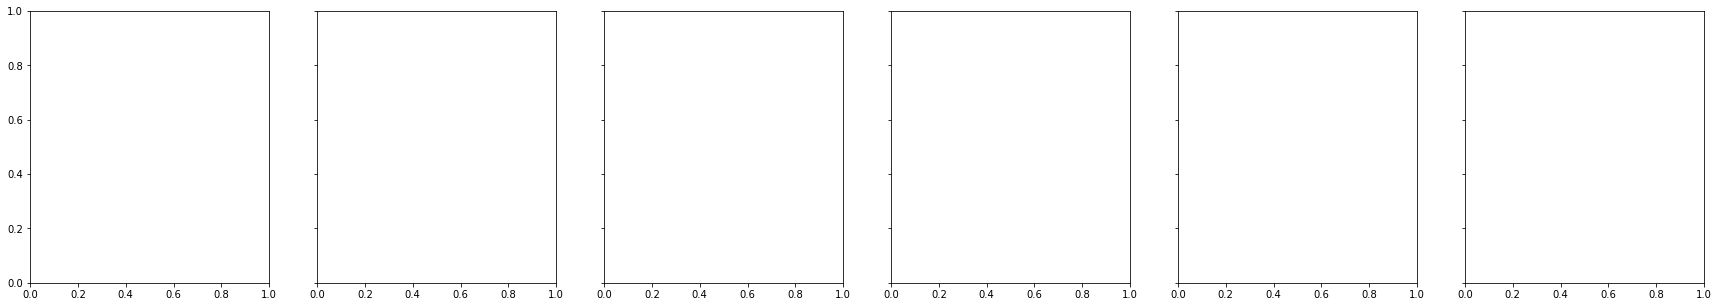

In [76]:
#MP586
from scipy.stats import linregress as linreg

# runlist=['1pctCO2','esmFixClim1']

modellist=['bcc-csm1-1','CanESM2','GFDL-ESM2M','HadGEM2-ES', 'IPSL-CM5A-LR','MPI-ESM-LR']

mi = 0
fig, ax = plt.subplots(1,6,sharey = True, sharex = True, figsize = (30,5))
for modelname in modellist:
    
    somoco = grab_cmip_dataset(cmip5_dict,modelname,'esmControl','mrso')
    somocomean = xr.DataArray(somoco['mrso'].mean(dim='time').sel(lat=slice(-30.,30.)))
    somoco_1d = np.asarray(somocomean).flatten()
    mask = ~np.isnan(somoco_1d)
    pr_ctl = grab_cmip_dataset(cmip5_dict,modelname,'esmControl','pr')
    pr_ctl_timemean = pr_ctl['pr'].mean(dim='time').sel(lat=slice(-30.,30.))*86400.
    
    print(pr_ctl.time)
    pr_pertb_coupled = grab_cmip_dataset(cmip5_dict,modelname,'1pctCO2','pr')
    pr_pertb_coupled_timemean = pr_pertb_coupled['pr'].isel(time = range((140-20)*12,140*12)).mean(dim='time').sel(lat=slice(-30.,30.))*86400.
    print(pr_pertb_coupled.time)
    
    pr_pertb_warming = grab_cmip_dataset(cmip5_dict,modelname,'esmFixClim1','pr')
    pr_pertb_warming_timemean = pr_pertb_warming['pr'].isel(time = range((140-20)*12,140*12)).mean(dim='time').sel(lat=slice(-30.,30.))*86400.
    print(pr_pertb_warming.time)
    lats = pr_pertb_warming_timemean.lat
    lons = pr_pertb_warming_timemean.lon
    
#     dP_warming = np.asarray(pr_pertb_warming_timemean - pr_ctl_timemean).flatten()
#     dP_coupled = np.asarray(pr_pertb_coupled_timemean - pr_ctl_timemean).flatten()
    
#     ax[mi].scatter(dP_warming[mask],dP_coupled[mask],s = 2.,label = modelname)
#     ax[mi].set_xlim(-4.,4.)
#     ax[mi].set_ylim(-4.,4.)
#     ax[mi].set_ylabel('$\Delta P$ Coupled (mm/d)')
#     ax[mi].set_xlabel('$\Delta P$ Warming (mm/d)')

#     ax[mi].legend(loc='upper left')
#     [k,dy,r,p,stderr] = linreg(dP_warming[mask],dP_coupled[mask]) # aa = 8.4, dq = -32
#     x1 = np.linspace(-4.,4.,500)
#     y = k*x1 + dy
#     ax[mi].plot(x1,y)
#     ax[mi].annotate('r = '+str("%.2f" % r)+', k = '+str("%.2f" % k)+', dy = '+str("%.2f" % dy), xy=(0.05,0.05), xycoords='axes fraction')
#     mi += 1
                                                                                                                
# plt.show()
    

### 1: Bar Graphs (x-axis: different models)

In [13]:
cmip_dict=cmip5_dict
modellist=['bcc-csm1-1','CanESM2','CESM1-BGC','GFDL-ESM2M','HadGEM2-ES', 'IPSL-CM5A-LR','NorESM1-ME'] #'MIROC-ESM','MPI-ESM-LR','BNU-ESM']
#modellist=['CESM2','CNRM-ESM2-1','GISS-E2-1-G','IPSL-CM6A-LR','MIROC6']
#'BCC-CSM2-MR'
varname='ET'
runname='1pctCO2'
latbounds = [ -45 ,  45 ]
weighted=1

In [14]:
## Calculate Change in variable

differences = np.zeros(len(modellist))

for i in np.arange(0,len(modellist)):
    modelname = modellist[i]
    print(modelname)

    ds = grab_cmip_dataset(cmip_dict,modelname,runname,varname)
    if ds != None:
        ds_land = cmip_dict[modelname +'_sftlf'] # in values of 0 to 100
        da_land = ds_land['sftlf']
        ds_area = cmip_dict[modelname +'_areacella']
        da_area = ds_area['areacella']

        ds_subset=ds.sel(lat=slice(*latbounds))
        da_land_subset = da_land.sel(lat=slice(*latbounds))
        lat_subset = ds_subset['lat'].values
        lon_subset = ds_subset['lon'].values
        var_subset = ds_subset[varname].values

        landaream2 = da_area*da_land/100
        landaream2 = landaream2.sel(lat=slice(*latbounds))
        landareaweights = landaream2/np.sum(np.sum(landaream2))
        #print((landareaweights))
        
        ds_annual = ds_subset.groupby('time.year').mean('time')
        [a2,b2,c2]=np.shape(ds_annual[varname].values)
        da_land_broadcast = np.tile(landareaweights.values, [a2,1,1])

        if weighted==1:
            plotvals = ds_annual[varname]*landareaweights
            var_subset_tseries = np.nansum(np.nansum(plotvals,1),1)
        else:
            plotvals = ds_annual[varname]
            var_subset_tseries = np.nanmean(np.nanmean(plotvals,1),1)

        time_year = (ds_annual['year'].values)
        a1=np.size(time_year)

        var_diff = var_subset_tseries[len_time-1]-var_subset_tseries[0]
        differences[i]=var_diff

bcc-csm1-1


NameError: name 'len_time' is not defined

ValueError: shape mismatch: objects cannot be broadcast to a single shape

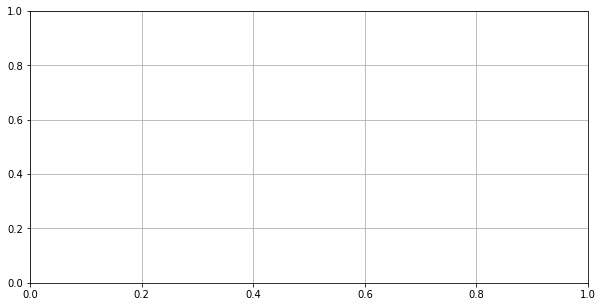

In [21]:
x_pos = np.arange(len(modellist))
fig1 = plt.figure(figsize=(10,5))
plt.grid()
plt.bar(x_pos,differences,align='center')
plt.xticks(x_pos,modellist)
plt.ylabel('Y Label')
plt.ylim([-0.4,0.4])

ax1=plt.axes()
ax1.set_axisbelow(True)

### 2: Plot Time Series (different lines for different models)

In [ ]:
co2_start= 284.317
co2_1pctco2 = np.zeros([140,1])

co2_1pctco2[0]=co2_start
len_time = 140
for i in np.arange(1,len_time):
    co2_1pctco2[i]=1.01*co2_1pctco2[i-1]

In [ ]:
cmip_dict=cmip5_dict
modellist=['bcc-csm1-1','CanESM2','CESM1-BGC','GFDL-ESM2M','HadGEM2-ES', 'IPSL-CM5A-LR','MIROC-ESM','MPI-ESM-LR','MRI-ESM1','BNU-ESM']
#['CESM2','CNRM-ESM2-1','GISS-E2-1-G','IPSL-CM6A-LR','MIROC6']
# 'CNRM-CM6-1' is weird - not sure why
modelname='CESM2'
varname='gpp'
runname='1pctCO2'
ylab_label=''
latbounds = [ -45 ,  45 ]
weighted=1


ind=0
for modelname in modellist:
    #print(modelname)

    ds = grab_cmip_dataset(cmip_dict,modelname,runname,varname)
    if ds != None:
        ds_land = cmip_dict[modelname +'_sftlf'] # in values of 0 to 100
        da_land = ds_land['sftlf']
        ds_area = cmip_dict[modelname +'_areacella']
        da_area = ds_area['areacella']

        ds_subset=ds.sel(lat=slice(*latbounds))
        da_land_subset = da_land.sel(lat=slice(*latbounds))
        lat_subset = ds_subset['lat'].values
        lon_subset = ds_subset['lon'].values
        var_subset = ds_subset[varname].values

        landaream2 = da_area*da_land/100
        landaream2 = landaream2.sel(lat=slice(*latbounds))
        landareaweights = landaream2/np.sum(np.sum(landaream2))
        #print((landareaweights))
        if ind==0:
            plotvals = ds_subset[varname].mean('time')*da_land_subset/100
            plotvals = plotvals.where(plotvals != 0)
            #print(np.shape(plotvals))
            #quick_map(plotvals,lat_subset,lon_subset,cmap='YlOrRd',show=True)

            fig1 = plt.figure(figsize=(10,5))
            ax1=plt.axes()

            ds_temp = grab_cmip_dataset(cmip_dict,modelname,runname,varname)
        ind=1
        ds_annual = ds_subset.groupby('time.year').mean('time')
        [a2,b2,c2]=np.shape(ds_annual[varname].values)
        da_land_broadcast = np.tile(landareaweights.values, [a2,1,1])

        if weighted==1:
            plotvals = ds_annual[varname]*landareaweights
            var_subset_tseries = np.nansum(np.nansum(plotvals,1),1)
        else:
            plotvals = ds_annual[varname]
            var_subset_tseries = np.nanmean(np.nanmean(plotvals,1),1)

        time_year = (ds_annual['year'].values)
        a1=np.size(time_year)

        ax1.plot(co2_1pctco2[0:len_time-5],var_subset_tseries[0:len_time-5],label=modelname)
fig.legend(modellist)
plt.ylabel(ylab_label)
plt.xlabel('Atmospheric CO2 Concentration')
plt.grid()
plt.legend()
#plt.ylim([0,2.5])

### 3: Plot Whittaker Plots

In [ ]:
modelname='CESM2'
varname='hfls'
runname='1pctCO2'
ds = grab_cmip_dataset(cmip6_dict,modelname,runname,varname)
ds_temp = grab_cmip_dataset(cmip6_dict,modelname,runname,'tas')
ds_precip = grab_cmip_dataset(cmip6_dict,modelname,runname,'hfls')

# calculate the difference between end of time series and beginning
delta = ds[varname].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')
delta = delta.values
lat = ds['lat'].values
lon = ds['lon'].values
temp = ds_temp['tas'].isel(time=range(20)).mean(dim='time')
temp = temp.values
precip = ds_precip['hfls'].isel(time=range(20)).mean(dim='time')
precip = precip.values
[latsize, lonsize] = np.shape(temp)

temp_flat = np.empty(np.size(temp))
precip_flat = np.empty(np.size(temp))
var_flat = np.empty(np.size(temp))
lat_flat = np.empty(np.size(temp))
lon_flat = np.empty(np.size(temp))

ind=0
for i in range(0,latsize):
    for j in range(0,lonsize):
        lat_flat[ind]=lat[i]
        lon_flat[ind]=lon[j]
        
        temp_flat[ind]= temp[i,j]
        precip_flat[ind]= precip[i,j]
        var_flat[ind]=delta[i,j]
        ind=ind+1

In [ ]:
print(np.max(var_flat))
print(np.min(var_flat))

plt.figure(figsize=(20,20))
clim=[-17,17]
fig = plt.figure(figsize=(8,7))
plt.scatter(temp_flat, precip_flat, c=var_flat, s=0.1, cmap=plt.cm.RdYlBu_r)
plt.title('Title',fontsize=16,y=1.05)
plt.clim(clim)  
cbar = plt.colorbar(orientation='vertical',extend='both',pad=.02, shrink=0.9)

### 4a: Plot Maps (average of all models)

In [22]:
runnamelist = ['1pctCO2']
#---- Loop over runs    
for rn in range(len(runnamelist)):
    runname = runnamelist[rn]

    #Loop over models
    for md in range(len(modellist)):
        modelname = modellist[md]

        #print(modelname +' ' +runname +' ' +varname)
        # get dataset
        ds = grab_cmip_dataset(cmip6_dict,modelname,runname,varname)

        if ds is not None: # 'ds' in locals():

            delta = ds[varname].isel(time=range((140-20)*12,140*12)).mean(dim='time') - ds[varname].isel(time=range(20)).mean(dim='time')
            print(np.shape(delta))

            mapdata = delta.values
            lat = ds['lat'].values
            lon = ds['lon'].values   

bcc-csm1-1_1pctCO2_evspsbl not in the dictionary
CanESM2_1pctCO2_evspsbl not in the dictionary
CESM1-BGC_1pctCO2_evspsbl not in the dictionary
GFDL-ESM2M_1pctCO2_evspsbl not in the dictionary
HadGEM2-ES_1pctCO2_evspsbl not in the dictionary
IPSL-CM5A-LR_1pctCO2_evspsbl not in the dictionary
NorESM1-ME_1pctCO2_evspsbl not in the dictionary
MIROC-ESM_1pctCO2_evspsbl not in the dictionary
MPI-ESM-LR_1pctCO2_evspsbl not in the dictionary
MRI-ESM1_1pctCO2_evspsbl not in the dictionary
BNU-ESM_1pctCO2_evspsbl not in the dictionary


In [ ]:
#########Make Figure###########################
cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())

plt.set_cmap(plt.cm.RdYlBu)
plt.title('Title')
#plt.clim(clim) 

# add a colorbar:
cbar = plt.colorbar(cax=cax,orientation='horizontal',extend='both')#,pad=.02, shrink=0.9) #use cax here, which means getting rid of pad
cbar.ax.tick_params(labelsize=14) 

# set color limits for the colorbar
cs.set_clim(clim)
cbar.set_clim(clim)

# put a label on the colorbar, e.g. with the units of your field
cbar.set_label(varname +' (' +unitname +')',fontsize=14)

# show the plot:
plt.show()

# save the plot
fig.savefig(plotfilepath +varname +'_' +runname +'_deltamaps.png', bbox_inches='tight')

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

### 4b: Plot Maps (1 for each model)

In [ ]:
varname ='hfss'
cmip_dict=cmip5_dict
modellist=['bcc-csm1-1','CanESM2','CESM1-BGC','GFDL-ESM2M','HadGEM2-ES', 'IPSL-CM5A-LR','MIROC-ESM','MPI-ESM-LR','MRI-ESM1','BNU-ESM']

unitname='mm/day'
cchoice = plt.cm.BrBG
clim = [-2, 2]
plot_allmaps_run(cmip_dict,['1pctCO2'],modellist,varname,clim,unitname,cmap=cchoice)

### Print Model Info

In [ ]:
varname='gpp'

for md in range(len(modellist)):
    modelname = modellist[md]  
    
    nametag = modelname +'_' +'1pctCO2' +'_' +varname
    if nametag in cmip_dict:
        print(nametag)
    else:
        print("NA")

# Misc

In [ ]:
varname='WUE'

#---- Loop over runs    
for rn in range(len(runnamelist)):
    runname = runnamelist[rn]
    print(runname)

    #fig,axes = plt.subplots(5,2,figsize=(10,15),subplot_kw={'projection': ccrs.Robinson()}) # also works to get projection into subplots
    fig = plt.figure(figsize=(15,10))


    #To loop over models and runs
    for md in range(len(modellist)):
        modelname = modellist[md]

        
        nametag = modelname +'_' +runname +'_' +varname
        #print('getting dataset for: ' +nametag)

        if nametag in cmip6_dict:
            del cmip6_dict[nametag]
